# Voting

In [1]:
# 패키지
import pandas as pd
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import warnings 
warnings.filterwarnings('ignore')

In [2]:
# 데이터
df_raw = load_breast_cancer()
import copy
df = copy.deepcopy(df_raw)
# 데이터 분할
X_train, X_test, Y_train, Y_test = train_test_split(df.data, df.target, test_size = 0.2, random_state = 156)
# Logistic Regression
lr = LogisticRegression(solver = 'liblinear')
knn = KNeighborsClassifier(n_neighbors = 8)
# Voting
vs = VotingClassifier(estimators = [('LR',lr),
                                    ('KNN',knn)],
                                    voting = 'soft')
vs.fit(X_train, Y_train)
y_pred = vs.predict(X_test)
accuracy = accuracy_score(Y_test, y_pred)
# 결과 확인
print('Voting 정확도 : {:.4f}'.format(accuracy))
# 개별 모델 결과 확인
model = [lr, knn]
for classifier in model :
    classifier.fit(X_train, Y_train)
    y_pred = classifier.predict(X_test)
    classifier_name = classifier.__class__.__name__
    print('{} 정확도 : {:.4f}'.format(classifier_name, accuracy_score(Y_test, y_pred)))

Voting 정확도 : 0.9561
LogisticRegression 정확도 : 0.9474
KNeighborsClassifier 정확도 : 0.9386


# Random Forest

In [3]:
# 이름 변경 함수
def get_new_name(old_feature_name_data) :
    feature_gb = pd.DataFrame(data = old_feature_name_data.groupby('column_name').cumcount(),
                              columns = ['cnt_gb'])
    feature_gb = feature_gb.reset_index()
    new_feature_name_data = pd.merge(old_feature_name_data.reset_index(),
                                     feature_gb,
                                     how = 'outer')
    new_feature_name_data['column_name'] = new_feature_name_data[['column_name','cnt_gb']].apply(lambda x : x[0] + '_' + str(x[1]) if x[1] > 0 else x[0], axis = 1)
    new_feature_name_data = new_feature_name_data.drop(['index'], axis = 1)
    
    return new_feature_name_data

def get_human_dataset( ):
    
    # 각 데이터 파일들은 공백으로 분리되어 있으므로 read_csv에서 공백 문자를 sep으로 할당.
    feature_name_df = pd.read_csv('./data_1/features.txt',sep='\s+',
                        header=None,names=['column_index','column_name'])
    
    # 중복된 피처명을 수정하는 get_new_feature_name_df()를 이용, 신규 피처명 DataFrame생성. 
    new_feature_name_df = get_new_name(feature_name_df)
    
    # DataFrame에 피처명을 컬럼으로 부여하기 위해 리스트 객체로 다시 변환
    feature_name = new_feature_name_df.iloc[:, 1].values.tolist()
    
    # 학습 피처 데이터 셋과 테스트 피처 데이터을 DataFrame으로 로딩. 컬럼명은 feature_name 적용
    X_train = pd.read_csv('./data_1/train/X_train.txt',sep='\s+', names=feature_name )
    X_test = pd.read_csv('./data_1/test/X_test.txt',sep='\s+', names=feature_name)
    
    # 학습 레이블과 테스트 레이블 데이터을 DataFrame으로 로딩하고 컬럼명은 action으로 부여
    y_train = pd.read_csv('./data_1/train/y_train.txt',sep='\s+',header=None,names=['action'])
    y_test = pd.read_csv('./data_1/test/y_test.txt',sep='\s+',header=None,names=['action'])
    
    # 로드된 학습/테스트용 DataFrame을 모두 반환 
    return X_train, X_test, y_train, y_test

In [4]:
# 패키지
from sklearn.ensemble import RandomForestClassifier as RFC

In [5]:
# 데이터 불러오기 및 분할
X_train, X_test, Y_train, Y_test = get_human_dataset()
# Random Forest
rf = RFC(random_state = 0, n_estimators = 100, max_depth = 8)
rf.fit(X_train, Y_train)
y_pred = rf.predict(X_test)
accuracy = accuracy_score(Y_test, y_pred)
# # 결과 확인
print('정확도 : {:.4f}'.format(accuracy))

정확도 : 0.9196


### GridSearchCV

In [6]:
# 시작 시간 설정
import time
start_time = time.time()
# parameter
para_grid = {'max_depth' : [8,16,24],
             'min_samples_leaf' : [1,6,12],
             'min_samples_split' : [2,8,16]
             }
# 설명력이 높은 최적 parameter 찾기
from sklearn.model_selection import GridSearchCV
rf = RFC(random_state = 0, n_estimators = 100, n_jobs = -1)
grid_rfc = GridSearchCV(rf,
                        para_grid,
                        cv = 2,
                        n_jobs = -1)
grid_rfc.fit(X_train, Y_train)
# 결과 확인
print('수행 시간 : {:.0f} 분 {:.0f} 초\n'.format((time.time() - start_time) // 60, (time.time() - start_time) % 60))
print('best estimator model: \n{}'.format(grid_rfc.best_estimator_))
print('\nbest parameter: \n{}'.format(grid_rfc.best_params_))
print('\nbest score: \n{:.4f}'.format(grid_rfc.best_score_))

수행 시간 : 1 분 17 초

best estimator model: 
RandomForestClassifier(max_depth=16, min_samples_leaf=6, n_jobs=-1,
                       random_state=0)

best parameter: 
{'max_depth': 16, 'min_samples_leaf': 6, 'min_samples_split': 2}

best score: 
0.9165


##### GridSearchCV 반영

In [7]:
rf = RFC(random_state = 0,
         n_estimators = 100,
         max_depth = 16,
         min_samples_leaf = 6,
         min_samples_split = 2)
rf.fit(X_train, Y_train)
y_pred = rf.predict(X_test)
accuracy = accuracy_score(Y_test, y_pred)
# 결과 확인
print('정확도 : {:.4f}'.format(accuracy))

정확도 : 0.9260


In [8]:
# Feature Importance
df_importance_values = rf.feature_importances_
df_importance = pd.Series(df_importance_values,
                          index = X_train.columns)
importance_top20 = df_importance.sort_values(ascending = False)[:20]
print(importance_top20)

angle(X,gravityMean)               0.035312
tGravityAcc-mean()-Y               0.033729
tGravityAcc-min()-X                0.030276
angle(Y,gravityMean)               0.029013
tGravityAcc-max()-X                0.027538
tGravityAcc-mean()-X               0.024708
tGravityAcc-energy()-X             0.024389
tGravityAcc-min()-Y                0.023339
tGravityAcc-max()-Y                0.021011
fBodyAccJerk-bandsEnergy()-1,8     0.018636
tGravityAcc-energy()-Y             0.015461
tBodyAcc-max()-X                   0.013750
tBodyAccJerk-entropy()-X           0.013433
tGravityAcc-arCoeff()-Z,1          0.013150
tGravityAcc-max()-Z                0.013125
fBodyAccMag-energy()               0.012262
tGravityAcc-energy()-Z             0.010683
fBodyAccJerk-bandsEnergy()-1,16    0.010095
fBodyAcc-mad()-X                   0.010036
angle(Z,gravityMean)               0.009483
dtype: float64


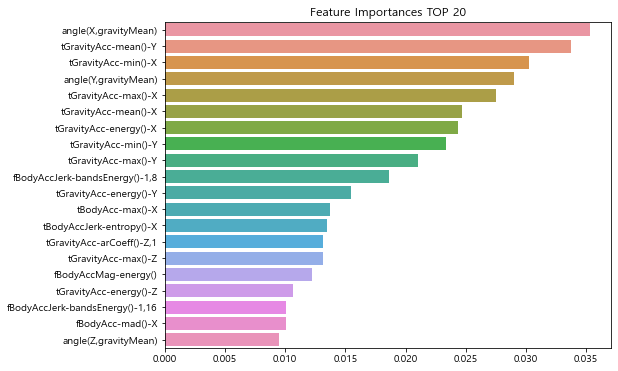

In [9]:
# 한글, 음수 표시
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rc('font', family = 'Malgun Gothic')
matplotlib.rc('axes', unicode_minus = False)
import seaborn as sns
# Graph
plt.figure(figsize = (8,6))
plt.title("Feature Importances TOP 20")
sns.barplot(x = importance_top20, y = importance_top20.index)
plt.show()

# Gradient Boosting

In [10]:
# 패키지
from sklearn.ensemble import GradientBoostingClassifier as GBC
# 데이터 불러오기 및 분할
X_train, X_test, Y_train, Y_test = get_human_dataset()
# 시작 시간 설정
start_time = time.time()
# Gradient Boosting
gb = GBC(random_state = 0)
gb.fit(X_train, Y_train)
y_pred = gb.predict(X_test)
accuracy = accuracy_score(Y_test, y_pred)
# 결과 확인
print('수행 시간 : {:.0f} 분 {:.0f} 초\n'.format((time.time() - start_time) // 60, (time.time() - start_time) % 60))
print('정확도 : {:.4f}'.format(accuracy))

수행 시간 : 29 분 26 초

정확도 : 0.9389


### GridSearchCV

In [ ]:
# 시작 시간 설정
start_time = time.time()
# parameter
para_grid = {'n_estimators' : [100,500],
             'learning_rate' : [0.05, 0.1]
             }
# 설명력이 높은 최적 parameter 찾기
grid_gbc = GridSearchCV(gb,
                        para_grid,
                        cv = 2,
                        verbose = 1)
grid_gbc.fit(X_train, Y_train)
# 결과 확인
print('수행 시간 : {:.0f} 분 {:.0f} 초\n'.format((time.time() - start_time) // 60, (time.time() - start_time) % 60))
print('best estimator model: \n{}'.format(grid_gbc.best_estimator_))
print('\nbest parameter: \n{}'.format(grid_gbc.best_params_))
print('\nbest score: \n{:.4f}'.format(grid_gbc.best_score_))

# XGBoost

In [11]:
# 패키지
import numpy as np
import xgboost as xgb
from xgboost import XGBClassifier as XGBC
from xgboost import plot_importance

In [12]:
# 데이터
df_raw = load_breast_cancer()
X_raw = df_raw.data
Y_raw = df_raw.target
df = pd.DataFrame(data = X_raw, columns = df_raw.feature_names)
df['target'] = Y_raw
df.head(3)

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.8,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.6,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.9,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.8,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.0,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.5,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0


In [13]:
# target
print(df_raw.target_names)
print(df['target'].value_counts())

['malignant' 'benign']
1    357
0    212
Name: target, dtype: int64


In [14]:
# x,y
X = df.iloc[:,:-1]
Y = df.iloc[:,-1]
# 데이터 분할(Train:Validation:Test = 7:1:2)
x_train, X_test, y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 156)
X_train, X_val, Y_train, Y_val = train_test_split(x_train, y_train, test_size = 0.1, random_state = 156)
print(x_train.shape, X_test.shape)
print(X_train.shape, X_val.shape)

(455, 30) (114, 30)
(409, 30) (46, 30)


In [15]:
# Dmatrix
train = xgb.DMatrix(data = X_train, label = Y_train)
val = xgb.DMatrix(data = X_val, label = Y_val)
test = xgb.DMatrix(data = X_test, label = Y_test)

In [16]:
# parameter
params = {'max_depth' : 3,
          'eta' : 0.05,
          'objective' : 'binary:logistic',
          'eval_metric' : 'logloss'
          }
num_rounds = 400

In [17]:
# xgboost
eval_list = [(train,'train'),(val,'val')]
xgb_model = xgb.train(params = params,
                      dtrain = train,
                      num_boost_round = num_rounds,
                      early_stopping_rounds = 50,
                      evals = eval_list)

[0]	train-logloss:0.65016	val-logloss:0.66183
[1]	train-logloss:0.61131	val-logloss:0.63609
[2]	train-logloss:0.57563	val-logloss:0.61144
[3]	train-logloss:0.54310	val-logloss:0.59204
[4]	train-logloss:0.51323	val-logloss:0.57329
[5]	train-logloss:0.48447	val-logloss:0.55037
[6]	train-logloss:0.45796	val-logloss:0.52930
[7]	train-logloss:0.43436	val-logloss:0.51534
[8]	train-logloss:0.41150	val-logloss:0.49718
[9]	train-logloss:0.39027	val-logloss:0.48154
[10]	train-logloss:0.37128	val-logloss:0.46990
[11]	train-logloss:0.35254	val-logloss:0.45474
[12]	train-logloss:0.33528	val-logloss:0.44229
[13]	train-logloss:0.31892	val-logloss:0.42961
[14]	train-logloss:0.30439	val-logloss:0.42065
[15]	train-logloss:0.29000	val-logloss:0.40958
[16]	train-logloss:0.27651	val-logloss:0.39887
[17]	train-logloss:0.26389	val-logloss:0.39050
[18]	train-logloss:0.25210	val-logloss:0.38254
[19]	train-logloss:0.24123	val-logloss:0.37393
[20]	train-logloss:0.23076	val-logloss:0.36789
[21]	train-logloss:0.22

[173]	train-logloss:0.01285	val-logloss:0.26253
[174]	train-logloss:0.01278	val-logloss:0.26229
[175]	train-logloss:0.01267	val-logloss:0.26086
[176]	train-logloss:0.01258	val-logloss:0.26103


In [20]:
# 결과 확인
import numpy as np
y_pred_prob = xgb_model.predict(test)
y_pred = [1 if x > 0.5 else 0 for x in y_pred_prob]
print('예측 확률\n', np.round(y_pred_prob[:10],4))
print('\n예측값 10개 표시\n', y_pred[:10])

예측 확률
 [0.8448 0.0084 0.6796 0.0811 0.9751 0.9989 0.9983 0.9981 0.9964 0.0014]

예측값 10개 표시
 [1, 0, 1, 0, 1, 1, 1, 1, 1, 0]


In [21]:
# 패키지 
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score
# clf_eval() 함수 생성 및 결과 확인
def clf_eval(y_test, pred = None, pred_proba = None) :
    cm = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    # 결과 출력
    print('오차행렬\n', cm)
    print('\n정확도 : {:.4f}\n정밀도 : {:.4f}\n재현율 : {:.4f}'.format(accuracy, precision, recall))
    # F1-score 추가
    f1 = f1_score(y_test, pred)
    print('F1 : {:.4f}'.format(f1))
    # ROC-AUC
    roc_auc = roc_auc_score(y_test, pred_proba)
    print('AUC : {:.4f}'.format(roc_auc))

In [22]:
# 성능 평가
clf_eval(Y_test, y_pred, y_pred_prob)

오차행렬
 [[34  3]
 [ 2 75]]

정확도 : 0.9561
정밀도 : 0.9615
재현율 : 0.9740
F1 : 0.9677
AUC : 0.9937


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

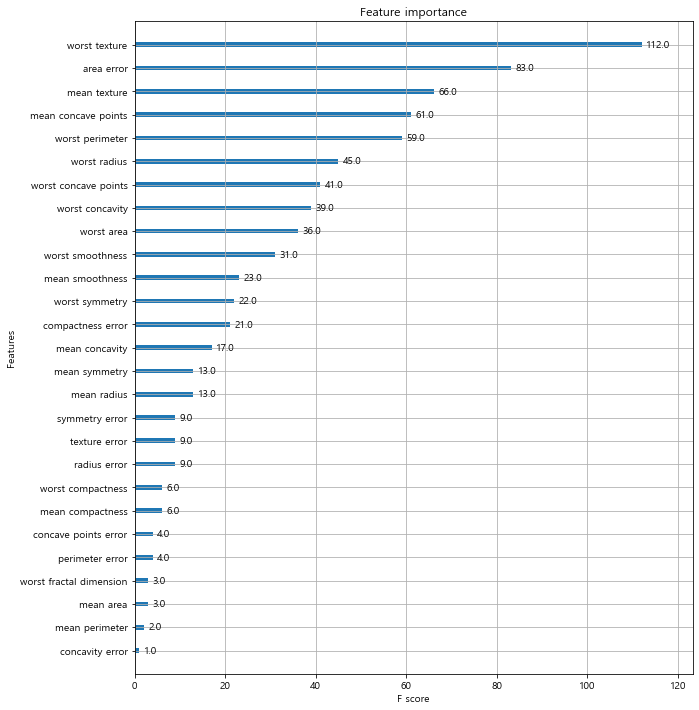

In [23]:
# Feature Importance
fig, ax = plt.subplots(figsize=(10, 12))
plot_importance(xgb_model, ax=ax)

### Wrapper

In [24]:
# wrapper 적용
xgb_wrapper = XGBC(n_estimators = 400,
                   learning_rate = 0.05,
                   max_depth = 3,
                   eval_metric = 'logloss')
xgb_wrapper.fit(x_train, y_train, verbose = True)
w_pred = xgb_wrapper.predict(X_test)
w_pred_proba = xgb_wrapper.predict_proba(X_test)[:,1]
# 결과 확인
clf_eval(Y_test, w_pred, w_pred_proba)

오차행렬
 [[34  3]
 [ 1 76]]

정확도 : 0.9649
정밀도 : 0.9620
재현율 : 0.9870
F1 : 0.9744
AUC : 0.9954


In [25]:
# early stopping 50
xgb_wrapper = XGBC(n_estimators = 400,
                   learning_rate = 0.05,
                   max_depth = 3)
evals = [(X_train, Y_train), (X_val, Y_val)]
xgb_wrapper.fit(X_train, Y_train,
                early_stopping_rounds = 50,
                eval_metric = 'logloss',
                eval_set = evals,
                verbose = True)
w50_pred = xgb_wrapper.predict(X_test)
w50_pred_proba = xgb_wrapper.predict_proba(X_test)[:,1]

[0]	validation_0-logloss:0.65016	validation_1-logloss:0.66183
[1]	validation_0-logloss:0.61131	validation_1-logloss:0.63609
[2]	validation_0-logloss:0.57563	validation_1-logloss:0.61144
[3]	validation_0-logloss:0.54310	validation_1-logloss:0.59204
[4]	validation_0-logloss:0.51323	validation_1-logloss:0.57329
[5]	validation_0-logloss:0.48447	validation_1-logloss:0.55037
[6]	validation_0-logloss:0.45796	validation_1-logloss:0.52930
[7]	validation_0-logloss:0.43436	validation_1-logloss:0.51534
[8]	validation_0-logloss:0.41150	validation_1-logloss:0.49718
[9]	validation_0-logloss:0.39027	validation_1-logloss:0.48154
[10]	validation_0-logloss:0.37128	validation_1-logloss:0.46990
[11]	validation_0-logloss:0.35254	validation_1-logloss:0.45474
[12]	validation_0-logloss:0.33528	validation_1-logloss:0.44229
[13]	validation_0-logloss:0.31892	validation_1-logloss:0.42961
[14]	validation_0-logloss:0.30439	validation_1-logloss:0.42065
[15]	validation_0-logloss:0.29000	validation_1-logloss:0.40958
[1

[130]	validation_0-logloss:0.01886	validation_1-logloss:0.25712
[131]	validation_0-logloss:0.01863	validation_1-logloss:0.25609
[132]	validation_0-logloss:0.01839	validation_1-logloss:0.25649
[133]	validation_0-logloss:0.01816	validation_1-logloss:0.25789
[134]	validation_0-logloss:0.01802	validation_1-logloss:0.25811
[135]	validation_0-logloss:0.01785	validation_1-logloss:0.25794
[136]	validation_0-logloss:0.01763	validation_1-logloss:0.25876
[137]	validation_0-logloss:0.01748	validation_1-logloss:0.25884
[138]	validation_0-logloss:0.01732	validation_1-logloss:0.25867
[139]	validation_0-logloss:0.01719	validation_1-logloss:0.25876
[140]	validation_0-logloss:0.01696	validation_1-logloss:0.25987
[141]	validation_0-logloss:0.01681	validation_1-logloss:0.25960
[142]	validation_0-logloss:0.01669	validation_1-logloss:0.25982
[143]	validation_0-logloss:0.01656	validation_1-logloss:0.25992
[144]	validation_0-logloss:0.01638	validation_1-logloss:0.26035
[145]	validation_0-logloss:0.01623	valid

In [26]:
# 성능 평가
clf_eval(Y_test, w50_pred, w50_pred_proba)

오차행렬
 [[34  3]
 [ 2 75]]

정확도 : 0.9561
정밀도 : 0.9615
재현율 : 0.9740
F1 : 0.9677
AUC : 0.9933


In [27]:
# early stopping 10
xgb_wrapper.fit(X_train, Y_train,
                early_stopping_rounds = 10,
                eval_metric = 'logloss',
                eval_set = evals,
                verbose = True)
w10_pred = xgb_wrapper.predict(X_test)
w10_pred_proba = xgb_wrapper.predict_proba(X_test)[:,1]

[0]	validation_0-logloss:0.65016	validation_1-logloss:0.66183
[1]	validation_0-logloss:0.61131	validation_1-logloss:0.63609
[2]	validation_0-logloss:0.57563	validation_1-logloss:0.61144
[3]	validation_0-logloss:0.54310	validation_1-logloss:0.59204
[4]	validation_0-logloss:0.51323	validation_1-logloss:0.57329
[5]	validation_0-logloss:0.48447	validation_1-logloss:0.55037
[6]	validation_0-logloss:0.45796	validation_1-logloss:0.52930
[7]	validation_0-logloss:0.43436	validation_1-logloss:0.51534
[8]	validation_0-logloss:0.41150	validation_1-logloss:0.49718
[9]	validation_0-logloss:0.39027	validation_1-logloss:0.48154
[10]	validation_0-logloss:0.37128	validation_1-logloss:0.46990
[11]	validation_0-logloss:0.35254	validation_1-logloss:0.45474
[12]	validation_0-logloss:0.33528	validation_1-logloss:0.44229
[13]	validation_0-logloss:0.31892	validation_1-logloss:0.42961
[14]	validation_0-logloss:0.30439	validation_1-logloss:0.42065
[15]	validation_0-logloss:0.29000	validation_1-logloss:0.40958
[1

In [28]:
# 성능 평가
clf_eval(Y_test, w10_pred, w10_pred_proba)

오차행렬
 [[34  3]
 [ 3 74]]

정확도 : 0.9474
정밀도 : 0.9610
재현율 : 0.9610
F1 : 0.9610
AUC : 0.9933


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

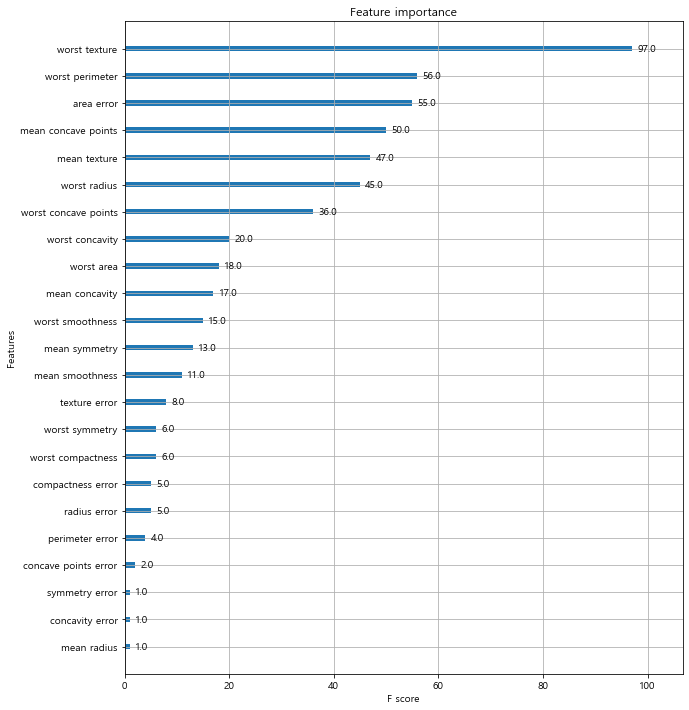

In [29]:
# Feature Importance
fig, ax = plt.subplots(figsize=(10, 12))
plot_importance(xgb_wrapper, ax=ax)

# LightGBM

In [30]:
# 패키지
from lightgbm import LGBMClassifier as LGBMC
# LightGBM
lgbm_wrapper = LGBMC(n_estimators = 400,
                     learning_rate = 0.05)
# early stopping 50
evals = [(X_train, Y_train), (X_val, Y_val)]
lgbm_wrapper.fit(X_train, Y_train,
                 early_stopping_rounds = 50,
                 eval_metric = 'logloss',
                 eval_set = evals,
                 verbose = True)
l_pred = lgbm_wrapper.predict(X_test)
l_pred_proba = lgbm_wrapper.predict_proba(X_test)[:,1]

[1]	training's binary_logloss: 0.625671	valid_1's binary_logloss: 0.628248
[2]	training's binary_logloss: 0.588173	valid_1's binary_logloss: 0.601106
[3]	training's binary_logloss: 0.554518	valid_1's binary_logloss: 0.577587
[4]	training's binary_logloss: 0.523972	valid_1's binary_logloss: 0.556324
[5]	training's binary_logloss: 0.49615	valid_1's binary_logloss: 0.537407
[6]	training's binary_logloss: 0.470108	valid_1's binary_logloss: 0.519401
[7]	training's binary_logloss: 0.446647	valid_1's binary_logloss: 0.502637
[8]	training's binary_logloss: 0.425055	valid_1's binary_logloss: 0.488311
[9]	training's binary_logloss: 0.405125	valid_1's binary_logloss: 0.474664
[10]	training's binary_logloss: 0.386526	valid_1's binary_logloss: 0.461267
[11]	training's binary_logloss: 0.367027	valid_1's binary_logloss: 0.444274
[12]	training's binary_logloss: 0.350713	valid_1's binary_logloss: 0.432755
[13]	training's binary_logloss: 0.334601	valid_1's binary_logloss: 0.421371
[14]	training's binary

In [31]:
clf_eval(Y_test, l_pred, l_pred_proba)

오차행렬
 [[34  3]
 [ 2 75]]

정확도 : 0.9561
정밀도 : 0.9615
재현율 : 0.9740
F1 : 0.9677
AUC : 0.9877


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

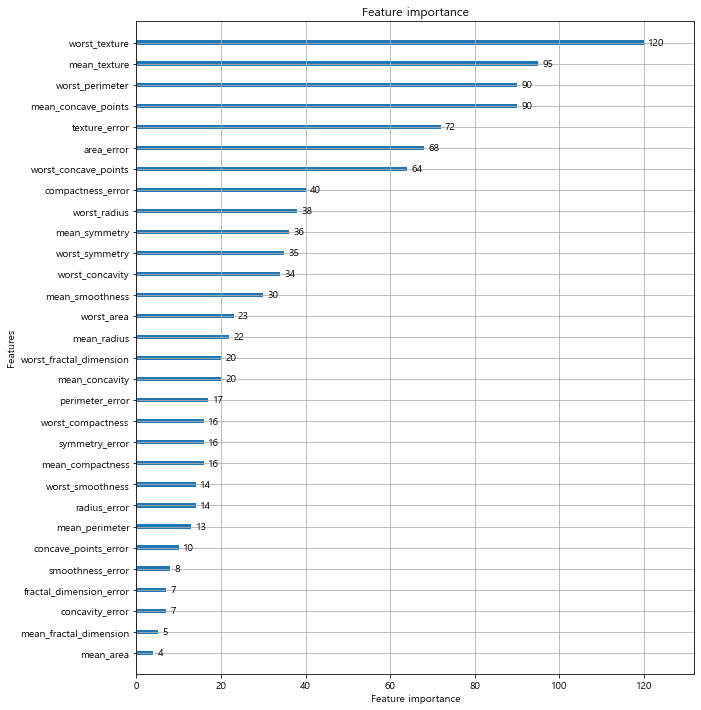

In [32]:
# Feature Importance
from lightgbm import plot_importance
fig, ax = plt.subplots(figsize=(10, 12))
plot_importance(lgbm_wrapper, ax=ax)